## Analysis for glutamate imaging

In [52]:
import matplotlib
matplotlib.use('module://ipympl.backend_nbagg')
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from utils_swim import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums, spearmanr
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Random Delay

### processing swim data

In [2]:
from pathlib import Path
from skimage.io import imread

In [3]:
rootDir = '/nrs/ahrens/Takashi/GlutamateImaging/'
folder = '04182019_Fish1-3_RandomDelay'
fish = 'Fish1-3-delay'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
dir_folder = Path(dat_folder)
# swim(folder, fish, rootDir, dat_folder)
# trial_swim_power(folder, fish, dir_folder)
# frame_swim_power(folder, fish, dir_folder)
# frame_swim_power_series(folder, fish, dir_folder)

### preprocessed dff data

In [4]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
img_dir = rootDir+folder+'/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]

In [5]:
# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0)
mask_ = ave>150
ave = ave.reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]
dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

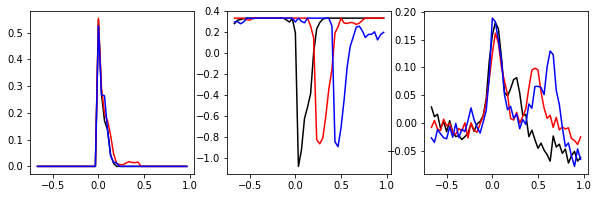

In [6]:
swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*10000
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
    valid_ = np.ones(pswim_.shape[0]).astype('bool')
    valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
    valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(3):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
plt.show()

### Random Gain

In [7]:
rootDir = '/nrs/ahrens/Takashi/GlutamateImaging/'
dat_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
folder = '04182019_Fish1-2_RandomGain'
fish = 'Fish1-2-random'
dir_folder = Path(dat_folder)
# swim(folder, fish, dat_folder, dat_folder)
# trial_swim_power(folder, fish, dir_folder)
# frame_swim_power(folder, fish, dir_folder)
# frame_swim_power_series(folder, fish, dir_folder)

In [8]:
# pamamters
swm_dir = dat_folder+f'{folder}/{fish}/swim/'
# swm_dir = rootDir+f'{folder}/swim/'
img_dir = rootDir+folder+'/Registered'

frame_rate = 30
t_pre = 20
t_post = 30 # 1 sec according to frame-rate
t_flat = 15
t_valid = 16

# get valid swim data
frame_stimParams = np.load(swm_dir+'frame_stimParams.npy', allow_pickle=True)[()];
frame_swim_tcourse = np.load(swm_dir+"frame_swim_tcourse_series.npy", allow_pickle=True)[()];
rawdata = np.load(swm_dir+"rawdata.npy", allow_pickle=True)[()]
swimdata = np.load(swm_dir+"swimdata.npy", allow_pickle=True)[()]
reclen=len(swimdata['fltCh1'])
frame_tcourse=np.zeros((reclen,))
frame=np.where(np.diff((rawdata['ch3']>3).astype('int'))==1)[0]
for t in range(len(frame)-1):
    frame_tcourse[frame[t]:frame[t+1]]=t
swim_start = frame_tcourse[np.where(swimdata['swimStartT']>0)[0]].astype('int')
swim_end = frame_tcourse[np.where(swimdata['swimEndT']>0)[0]].astype('int')
# collect trial within t-pre, and t-post valid range
swim_end   = swim_end[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]
swim_start = swim_start[((swim_start>t_pre) & (swim_start<(frame_swim_tcourse.shape[1]-t_post)))]

In [9]:
# get dff data
dFF = np.load(img_dir+'/dFF_sub.npy')[()]
dim = dFF.shape
dFF = dFF.reshape((dim[0],dim[1]*dim[2]),order='F') # dFF reshaped to t x pixels

# remove pixels with low light intensity

# ave = imread(img_dir+'/ave.tif')
ave = np.load(img_dir+'/stack_sub.npy')[()]
ave = ave.mean(axis=0).reshape((1,dim[1]*dim[2]),order='F')
include_pix=np.where(ave>150)[1]

dFF = dFF[:, include_pix]
n_pix = dFF.shape[-1]

## motor control

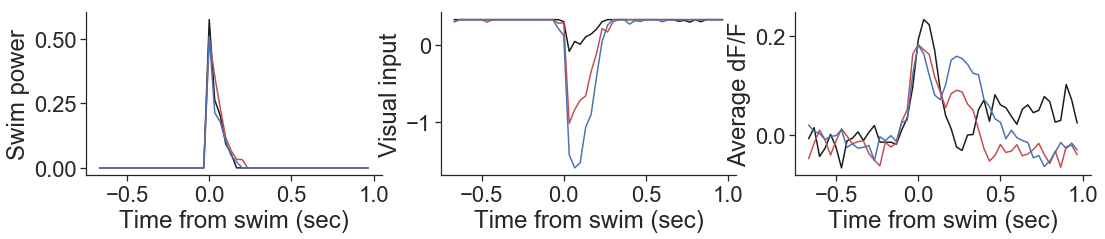

In [92]:
swim_list = []
for ntype in range(3):
    _ = swim_start[np.where(frame_stimParams[2,swim_start+2]==ntype+1)[0]]
    valid = np.diff(_) > t_post
    swim_list.append(_[:-1][valid])

dff_list = []
pswim_list = []
vis_list = []
num_swim_list = []
t_len = int(t_pre+t_post)
for nswim in swim_list:
    num_swim = len(nswim)
    num_swim_list.append(num_swim)
    dff_ = np.zeros((num_swim, t_len, n_pix))
    pswim_ = np.zeros((num_swim, t_len))
    vis_ = np.zeros((num_swim, t_len))
    for ns, s in enumerate(nswim):
        l_swim = frame_swim_tcourse[1,(s-t_pre):(s+t_post)]
        r_swim = frame_swim_tcourse[2,(s-t_pre):(s+t_post)]
        pswim_[ns] = np.sqrt(l_swim**2 + r_swim**2)*10000
        vis_[ns] = -frame_stimParams[0,(s-t_pre):(s+t_post)]*10000
        dff_[ns] = dFF[(s-t_pre):(s+t_post), :] - dFF[(s-t_flat):s, :].mean(axis=0, keepdims=True)
    valid_ = pswim_[:, -t_valid:].sum(axis=-1)==0
    valid_ = valid_ & (pswim_.max(axis=-1)<2)
    valid_ = valid_ & (pswim_[:, :t_pre].sum(axis=-1)==0)
    dff_list.append(dff_[valid_])
    pswim_list.append(pswim_[valid_])
    vis_list.append(vis_[valid_])

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
ax = ax.flatten()
color_list = ['k', 'r', 'b']
for n in range(3):
    ax[0].plot(np.arange(-t_pre, t_post)/frame_rate, pswim_list[n].mean(axis=0), color_list[n])
    ax[1].plot(np.arange(-t_pre, t_post)/frame_rate, vis_list[n].mean(axis=0), color_list[n])
    ax[2].plot(np.arange(-t_pre, t_post)/frame_rate, dff_list[n].mean(axis=0).mean(axis=-1)*100, color_list[n])
    sns.despine()
ax[0].set_ylabel('Swim power')
ax[0].set_xlabel('Time from swim (sec)')
ax[1].set_ylabel('Visual input')
ax[1].set_xlabel('Time from swim (sec)')
ax[2].set_ylabel('Average dF/F')
ax[2].set_xlabel('Time from swim (sec)')
plt.show()

SpearmanrResult(correlation=-0.6, pvalue=0.01805008794149996)
SpearmanrResult(correlation=0.1878260869565217, pvalue=0.37945849831738243)
SpearmanrResult(correlation=-0.16638655462184873, pvalue=0.3469709562221872)


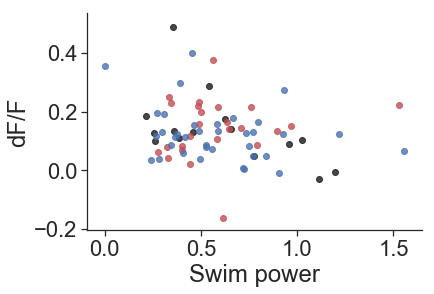

SpearmanrResult(correlation=-0.13194805194805193, pvalue=0.25586935787858256)

In [109]:
tmp1 = []
tmp2 = []
for n in range(3):
    ave_dff = dff_list[n].mean(axis=-1)*100
    p_ = pswim_list[n][:, :].max(axis=-1)
    d_ = ave_dff[:, t_pre-2:t_pre+2].mean(axis=-1)
    tmp1.append(p_)
    tmp2.append(d_)
    plt.scatter(p_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    print(spearmanr(p_[p_<1.2], d_[p_<1.2]))
plt.xlabel('Swim power')
plt.ylabel('dF/F')
# plt.legend()
sns.despine()
plt.show()
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

SpearmanrResult(correlation=0.34642857142857136, pvalue=0.2058959920935512)
SpearmanrResult(correlation=0.26692307692307693, pvalue=0.1971058089027914)
SpearmanrResult(correlation=0.2012870012870013, pvalue=0.23911746582756346)


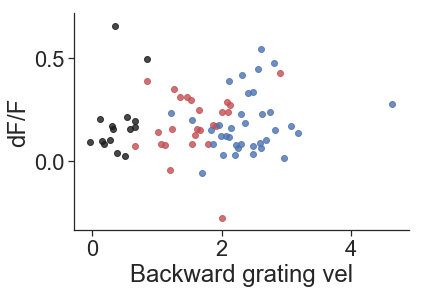

SpearmanrResult(correlation=0.10310321257689678, pvalue=0.3754550432681836)

In [89]:
tmp1 = []
tmp2 = []
for n in range(3):
    ave_dff = dff_list[n].mean(axis=-1)*100
    v_ = -vis_list[n][:, :].min(axis=-1)
    d_ = ave_dff[:, t_pre:t_pre+1].mean(axis=-1)
    tmp1.append(v_)
    tmp2.append(d_)
    plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
    print(spearmanr(v_, d_))
plt.xlabel('Backward grating vel')
plt.ylabel('dF/F')
# plt.legend()
sns.despine()
plt.show()
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))

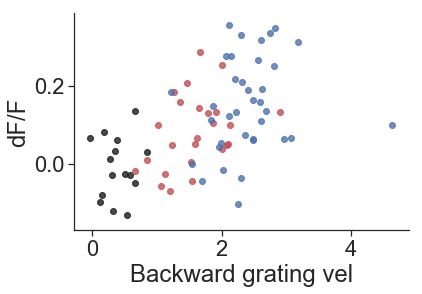

SpearmanrResult(correlation=0.5704989747095011, pvalue=7.439192430124858e-08)

In [88]:
tmp1 = []
tmp2 = []
for n in range(3):
    ave_dff = dff_list[n].mean(axis=-1)*100
    v_ = -(vis_list[n][:, :].min(axis=-1))
    d_ = ave_dff[:, t_pre+6:t_pre+10].mean(axis=-1)
    tmp1.append(v_)
    tmp2.append(d_)
    plt.scatter(v_, d_, c=color_list[n], label=f'Gain #{n}', alpha=0.8)
plt.xlabel('Backward grating vel')
plt.ylabel('dF/F')
# plt.legend()
sns.despine()
plt.show()
spearmanr(np.concatenate(tmp1), np.concatenate(tmp2))